# An&aacute;lisis de sentimientos para rese&ntilde;as de Airbnb

El presente proyecto aborda una de las aplicaciones m&aacute;s interesantes al momento de trabajar con el **Procesamiento del Lenguage Natural (PLN)** con Python, que consiste en el **An&aacute;lisis de Sentimientos** aplicado a un conjunto de datos reales de muestra correspondientes a 620 rese&ntilde;as otorgadas por hu&eacute;spedes a un total de 10 alojamientos listados dentro de la plataforma de alojamientos temporales *Airbnb* para la ic&oacute;nica ciudad tur&iacute;stica ecuatoriana con playas &uacute;nicas y gente muy acogedora que es **Monta&ntilde;ita**.

Este proyecto cumple con los lineamientos de estilo y formato de código dictados en el manual ***PEP-8***, adem&aacute;s de ***Entidades HTML*** para ayudar a la correcta legibilidad de caracteres especiales, tales como *tildes* y *&ntilde;*.

# Preprocesamiento inicial de la informaci&oacute;n

## Instalaci&oacute;n e importaci&oacute;n de librer&iacute;as necesarias

Debido a que varias de las rese&ntilde;as contienen *emojis*, ser&aacute; necesario contar con una librer&iacute;a para su respectivo tratamiento y transformaci&oacute;n, para posteriormente emplearlos al momento de realizar el an&aacute;lisis de sentimientos. La librer&iacute;a que se instala se llama ***emoji***.

In [1]:
try:
    import emoji
except ImportError:
    !pip install emoji
    import emoji

Se importan adem&aacute;s liber&iacute;as como ***pandas***, ***numpy***, ***os***, ***glob*** y ***pathlib***, mismas que servir&aacute;n para diferentes prop&oacute;sitos, desde la manipulaci&oacute;n de archivos y carpetas dentro de la m&aacute;quina virtual hasta la creaci&oacute;n de ***DataFrames*** y el uso de funciones matem&aacute;ticas.

In [2]:
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path

Se configura pandas para evitar que trunque el texto de las entradas de cada una de las columnas. Adicionalmente, se cambia el directorio base con la librer&iacute;a ***os*** para una mayor facilidad de trabajo. En el directorio base est&aacute;n contenidas las rese&ntilde;as dejadas por hu&eacute;spedes de un total de 10 alojamientos diferentes ubicados en la playa de Monta&ntilde;ita, Ecuador, con corte a la fecha del viernes, 06 de enero de 2024.

In [3]:
default_max_colwidth = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', None)

El bloque de c&oacute;digo contenido en la siguiente celda se debe ejecutar &uacute;nicamente si los archivos del ***notebook*** se almacenan en ***Google Drive*** y si adem&aacute;s este se ejecuta dentro de la plataforma de ***Google Colab***, para lo cual es necesario reemplazar *root_path* con la ruta correspondiente al directorio ra&iacute;z donde se almacenar&aacute;n los archivos. Esto es a fin de que en celdas posteriores no sea necesario escribir la ruta completa cada vez.

Por el contrario, si se ejecuta el ***notebook*** en un entorno local, se puede omitir por completo la celda.

In [4]:
root_path = "/content/drive/MyDrive/PORTFOLIO/Sent_Analysis"
if os.path.exists(root_path):
    reviews_path = os.path.join(root_path, "abb_reviews")
    os.chdir(root_path)
else:
    reviews_path = "./abb_reviews"
# Verificación de cambio de directorio
print(f"Directorio actual: {os.getcwd()}")

Directorio actual: /home/carlos/PORTFOLIO/airbnb-sentiment-analysis


Se obtiene un listado con todos los arhivos correspondientes a las rese&ntilde;as de 10 alojamientos en total.

In [5]:
# Se define un patrón para buscar archivos txt en el directorio
patron = '*.txt'

# Se usa glob para obtener la lista de archivos que coinciden con el patrón
abb_reviews = glob.glob(os.path.join(reviews_path, patron))

# Se ordenan las reseñas en orden alfabético
abb_reviews = sorted(
    abb_reviews,
    key=lambda x: int(Path(x).stem.split('_')[-1]))

## Conteo de rese&ntilde;as por cada archivo

In [6]:
total_resenas = 0
for archivo in abb_reviews:
    archivo_path = Path(archivo)
    with open(archivo_path, mode="r", encoding="utf-8") as file:
        foo = file.read()
        print(f'Número de reseñas en {archivo_path.name}:\
         {foo.count("Calificación: ")}')
        total_resenas += foo.count("Calificación: ")

print(f"\nTotal de reseñas en {len(abb_reviews)} archivos: {total_resenas}")

Número de reseñas en abb_reviews_00.txt:         9
Número de reseñas en abb_reviews_01.txt:         17
Número de reseñas en abb_reviews_02.txt:         141
Número de reseñas en abb_reviews_03.txt:         15
Número de reseñas en abb_reviews_04.txt:         38
Número de reseñas en abb_reviews_05.txt:         8
Número de reseñas en abb_reviews_06.txt:         200
Número de reseñas en abb_reviews_07.txt:         29
Número de reseñas en abb_reviews_08.txt:         22
Número de reseñas en abb_reviews_09.txt:         141

Total de reseñas en 10 archivos: 620


## Funci&oacute;n para extraer las rese&ntilde;as de hu&eacute;spedes de todos los archivos

Puede verse que parte de la informaci&oacute;n recopilada no est&aacute; previamente estructurada, es decir, hay comentarios con atributos diferentes a otros, tales como, por ejemplo, "*Se qued&oacute; unas semanas*" o "*Con mascota*". Es por esto que dichas expresiones son eliminadas para evitar que sean err&oacute;neamente interpretadas como comentarios.

In [7]:
def extraer_comentarios(mi_archivo):
    comentarios = []
    with open(mi_archivo, mode="r", encoding="utf-8") as file:
        texto = file.read()

    # Dividir el texto en fragmentos usando "Calificación:" como delimitador
    fragmentos = texto.split("Calificación:")[1:]

    # Eliminación de fragmentos vacíos
    fragmentos = [
        fragmento.strip() for fragmento in fragmentos if fragmento.strip()
    ]
    for fragmento in fragmentos:
        aux = (
            fragmento.replace(",·", "")
            .replace("Se quedó unas semanas", "")
            .replace("Estadía de una semana", "")
            .replace("Con mascota", "")
        )
        aux = "\n".join(
            linea.strip() for linea in aux.splitlines() if linea.strip()
        )
        comentarios.append(aux.splitlines()[2])

    return comentarios

Se crea una lista para en ella guardar todas las rese&ntilde;as (que a su vez est&aacute;n en listas) las cuales serán almacenadas en un ***DataFrame de Pandas*** junto con las calificaciones.

In [8]:
lista_reviews = []

In [9]:
for review_file in abb_reviews:
    lista_reviews.append(extraer_comentarios(review_file))

Se verifica con la funci&oacute;n ***len*** que existan efectivamente ***620*** rese&ntilde;as en total, lo cual se cumple, y posteriormente se crea un archvo de texto plano para verificar los comentarios.

In [10]:
print(len(sum(lista_reviews, [])))

620


Se guardan todas las rese&ntilde;as en un archivo de texto para comprobar de manera manual mediante un editor de textos externo que cada una de las 620 l&iacute;neas correspondientes a comentarios son efectivamente comentarios y no otros de los atributos de las rese&ntilde;as.

In [11]:
if not os.path.exists("./processing"):
    os.mkdir("./processing")
if not os.path.exists("processing/coment_ALL.txt"):
    with open("processing/coment_ALL.txt", mode="w") as file:
        file.write("\n".join(sum(lista_reviews, [])))

## Funci&oacute;n para extraer las calificaciones de hu&eacute;spedes de todos los archivos

Adicionalmente, para el an&aacute;lisis de sentimientos es importante extraer la calificaci&oacute;n del 1 al 5 que dieron los usuarios en cada una de las rese&ntilde;as para contrastarlas con el resultado del an&aacute;lisis de sentimientos. Al igual que con los comentarios en s&iacute;, las puntuaciones se almacenan tambi&eacute;n en formato de listas para despu&eacute;s crear un ***DataFrame de Pandas*** con estas.

In [12]:
def extraer_calificaciones(mi_archivo):
    stars = []
    with open(mi_archivo, mode="r", encoding="utf-8") as file:
        texto = file.read()
        fragmentos = texto.split("Calificación: ")

    for i in range(1, len(fragmentos)):
        stars.append(int(fragmentos[i][0]))

    return stars

In [13]:
lista_stars = []

for review_file in abb_reviews:
    lista_stars.append(extraer_calificaciones(review_file))

Se verifica que la cantidad de calificaciones sea la misma que de comentarios.

In [14]:
len(sum(lista_stars, []))

620

Se crean los &iacute;ndices para identificar a cada uno de los 10 alojamientos previo a la creaci&oacute;n del *DataFrame* de *Pandas*. As&iacute;mismo, se unen todos los elementos de rese&ntilde;as y n&uacute;mero de estrellas de cada alojamiento en una &uacute;nica lista para cada caso.

In [15]:
def unir_listas(lista):
    return sum(lista, [])

In [16]:
numero_resenas = []

In [17]:
for resena in lista_reviews:
    numero_resenas.append(len(resena))

In [18]:
numero_resenas

[9, 17, 141, 15, 38, 8, 200, 29, 22, 141]

In [19]:
id_alojamiento = []
for index, i in enumerate(numero_resenas, start=0):
    id_alojamiento.append(list(np.full(i, index)))

id_alojamiento = sum(id_alojamiento, [])

In [20]:
lista_reviews = unir_listas(lista_reviews)
lista_stars = unir_listas(lista_stars)

## Construcci&oacute;n de DataFrame de Pandas

In [21]:
df_reviews = pd.DataFrame({
    "id_alojamiento": id_alojamiento,
    "review": lista_reviews,
    "stars": lista_stars,
})

Se realiza un muestreo a fin de verificar que el *DataFrame* fue construido de manera correcta y se procede a guardar el mismo en formato *csv* para uso futuro.

In [22]:
df_reviews.sample(5)

,id_alojamiento,review,stars
330,6,"El departamento es limpio, bien ubicado, tiene todo lo necesario y está cerca del centro y la olaya. Jonny está pendiente de todo.",4
362,6,"Gabe has a perfect place if you want to stay a couple of nights and don't plan on staying in the apartment. We had a great location with parking and easy entry. It was probably a bit smaller than we thought, but it was enough for us to have a great trip.",4
454,7,"The host is very responsive, respectful, and kind. She gave us good information before and during our stay. However, we were not satisfied with the cleanness of the entire place, especially the bed sheets and kitchen area.",2
47,2,"un lugar muy bonito para pasar unos dias,",5
341,6,"lindo lugar, muy práctico",4


In [23]:
if not os.path.exists("processing/df_reviews.csv"):
    df_reviews.to_csv("processing/df_reviews.csv", index=False)

A continuaci&oacute;n, se procede a traducir las rese&ntilde;as dejadas por los hu&eacute;spedes a los alojamientos con la ayuda de **Google Cloud Translate**, el cual detecta de manera autom&aacute;tica el idioma de los textos de entrada y los traduce al ingl&eacute;s a fin de procesarlos posteriormente al momento de realizar el an&aacute;lisis de sentimientos.

Para las ejecuciones posteriores del presente *Jupyter Notebook*, se importa el archivo con las rese&ntilde;as ya traducidas a fin de no exceder la cuota de traducciones permitidas en la capa gratuita de *Google Cloud Translate*.

En caso de que se quiera replicar el uso de ***Google Cloud Translate*** para la traducci&oacute;n autom&aacute;tica de textos se deber&aacute; utilizar una cuenta existente de ***Google Cloud*** o crear una nueva cuenta y generar las credenciales de acceso a la API, siguiendo para ello la documentaci&oacute;n del proveedor de servicios en la nube.

La raz&oacute;n por la cual se almacenan los datos en formato *.xlsx* en lugar de *.csv* radica en que en algunas ocasiones el int&eacute;rprete de ***Pandas*** confunde ciertos caracteres especiales con delimitadores de datos y se produce una lectura err&oacute;nea para algunos de los registros.

In [24]:
df_traducciones = pd.DataFrame()

In [25]:
from google.cloud import translate_v2 as translate

if not os.path.exists("translations/df_reviews_traducido.xlsx"):
    # Lectura de llave privada de la API de Google Cloud Translate
    client = translate.Client.from_service_account_json(
        "processing/private_key_translate.json"
    )
    # Función para traducir un texto
    def translate_text(text, target_language='en'):
        result = client.translate(text, target_language=target_language)
        return result['translatedText']

    # Traducción de texto en la columna "review"
    df_reviews['texto_traducido'] = df_reviews["review"].apply(
        lambda x: translate_text(x, target_language="en")
    )

    # Almacenamiento de reseñas traducidas para uso futuro
    df_reviews[[
            "id_alojamiento", "review", "texto_traducido", "stars"
        ]].to_excel(
        "translations/df_reviews_traducido.xlsx", index=False
    )

else:
    df_reviews['texto_traducido'] = pd.read_excel(
        "translations/df_reviews_traducido.xlsx"
    )["texto_traducido"]

Se obtiene una muestra aleatoria de los datos a fin de verificar las traducciones realizadas.

In [26]:
df_reviews.sample(10)

,id_alojamiento,review,stars,texto_traducido
550,9,Súper bien !!!,5,Super good !!!
270,6,"La verdad no le doy las 5 estrellas porque la cama estaba con algo de polvo y sería recomendable cambiar o lavar y aspirar porque mi novia y yo tuvimos alergias. El otro detalle es que el camino de ma entrada estuvo algo peligroso en caso de lluvia y mucha maleza a los lados que provocan mosquitos, de ahí todo perfecto me gusto porque es acogedor, pude hubo una vista muy linda",3,"The truth is I don&#39;t give it 5 stars because the bed was a little dusty and it would be advisable to change or wash and vacuum because my girlfriend and I had allergies. The other detail is that my entrance path was somewhat dangerous in case of rain and there was a lot of weeds on the sides that caused mosquitoes, hence everything was perfect. I liked it because it is cozy, I was able to have a very nice view."
35,2,"El check-in muy demorado y no respondían, estábamos dos huéspedes a la vez esperando para poder ingresar y la persona encargada nunca respondío",4,"The check-in was very delayed and they did not respond, we were two guests at a time waiting to enter and the person in charge never responded"
143,2,"Atención buena y rápida de los anfitriones, muy amables.",5,"Good and quick attention from the hosts, very friendly."
27,2,"El encargado es muy amable, el departamento es bien precioso, muy cómodo para pasarla bien y estar tranquilos.",5,"The manager is very friendly, the apartment is very beautiful, very comfortable to have a good time and be calm."
457,8,Me gustó mucho este lugar. Está a unos 15 minutos de la playa pero la privacidad y ambiente que ofrece vale definitivamente la pena. Disfruté mucho mi estadía!,5,I really liked this place. It is about 15 minutes from the beach but the privacy and atmosphere it offers is definitely worth it. I really enjoyed my stay!
374,6,"Es un lugar muy agradable sobre todo por su diseño arquitectónico y decoración, la vista es linda y esta alejado del ruido de la ciudad pero lo suficiente cerca para llegar al pueblo en 3 minutos caminando, la cerradura no es muy segura y el WiFi no funcionó, la limpieza podría mejorar, de ahí el lugar es perfecto y tiene todo incluso una nevera y aire acondicionado que funcionba muy bien",3,"It is a very nice place especially for its architectural design and decoration, the view is beautiful and it is away from the noise of the city but close enough to reach the town in 3 minutes walking, the lock is not very secure and the WiFi did not work , the cleanliness could improve, hence the place is perfect and has everything including a refrigerator and air conditioning that worked very well"
460,8,"Die Unterkunft ist super! Die Lage ist perfekt, 10 Minuten zum nächsten Supermarkt, 10 Minuten zum Strand, 10 Minuten zu Bars und Discos. Trotzdem ist es bei der Unterkunft ruhig und man kann in Ruhe schlafen. Der Host ist auch sehr nett und hilfsbereit!",5,"The accommodation is great! The location is perfect, 10 minutes to the nearest supermarket, 10 minutes to the beach, 10 minutes to bars and discos. Nevertheless, the accommodation is quiet and you can sleep in peace. The host is also very nice and helpful!"
510,9,Awesome place. 5 minute walk to the water. Loved the chill town vibe.,5,Awesome place. 5 minute walk to the water. Loved the chill town vibe.
542,9,Liliana and Gijs’s place is a little gem. We stayed with them for about a week and got to talk to them a couple of times. They truly love hosting their guests and they have put a lot of thought into providing a wonderful airbnb experience.,5,Liliana and Gijs’s place is a little gem. We stayed with them for about a week and got to talk to them a couple of times. They truly love hosting their guests and they have put a lot of thought into providing a wonderful airbnb experience.


# Preparaci&oacute;n de los datos para el Análisis de Sentimientos

##: Elminaci&oacute;n de signos de puntuaci&oacute;n, art&iacute;culos y palabras innecesarias:

Se importa la librer&iacute;a **nltk** detectar y eliminar de los comentarios dejados por los hu&eacute;spedes y traducidos previamente al ingl&eacute;s, los art&iacute;culos, palabras y signos de puntuaci&oacute;n que no van a ser de utilidad al momento de realizar el an&aacute;lisis de sentimientos, y se almacena en una nueva columna del *DataFrame* llamada "*texto_sin_stopwords*".

In [27]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')


def remover_articulos(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

[nltk_data] Downloading package stopwords to /home/carlos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/carlos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
df_reviews["texto_sin_stopwords"] = df_reviews["texto_traducido"].apply(
    lambda x: remover_articulos(x)
)

Se ocupan adem&aacute;s expresiones regulares para dar tratamientos tanto a los espacios sobrantes como a los signos de puntuaci&oacute;n y caracteres innecesarios para el an&aacute;lisis de sentimientos. Adem&aacute;s se preparan los datos para el tratamiento de emojis.

In [29]:
import re


def extraer_no_letras(texto):
    return list(set(re.sub('[a-zA-Z0-9]', '', texto)))

In [30]:
df_reviews["no_texto"] = df_reviews["texto_sin_stopwords"].apply(
    lambda x: extraer_no_letras(x)
)

In [31]:
non_text_chars = list(set(df_reviews["no_texto"].sum()))
non_text_chars.remove(" ")
df_reviews.drop(["no_texto"], axis=1, inplace=True)

## Tratamiento de emojis

Se extrae de la variable definida anteriormente "*non_text_chars*", una lista de todos los emojis presentes en las rese&ntilde;as otorgadas por los hu&eacute;spedes.

Adicionalmente, se asigna una palabra en ingl&eacute;s para dar una interpretaci&oacute;n adecuada a cada uno de estos.

Por &uacute;ltimo, se reemplazan los emojis con sus equivalentes en palabras.

In [32]:
import emoji

emojis_list = [i for i in non_text_chars if emoji.is_emoji(i)]
emojis_dict = {
    '✨': 'sparkling',
    '🙃': 'sarcastic',
    '💖': 'beautiful',
    '😔': 'sad',
    '🙌': 'celebration',
    '😘': 'affectionate',
    '⭐': 'star',
    '👏': 'applause',
    '💕': 'affectionate',
    '😊': 'happy',
    '😍': 'admiration',
    '💓': 'emotion',
    '❣': 'emotion',
    '💜': 'affection',
    '🙈': 'playful',
    '🤗': 'friendly',
    '👌': 'approval',
    '🏻': '',
    '🍻': 'celebration',
    '🌞': 'cheerful',
    '❤': 'love',
    '♥': 'love',
    '💯': 'perfect',
    '👍': 'approval'
}

In [33]:
non_emoji_chars = [i for i in non_text_chars if not emoji.is_emoji(i)]

In [34]:
def quitar_simbolos(texto):
    for char in non_emoji_chars:
        texto = texto.replace(char, "")
    return texto

In [35]:
df_reviews["texto_sin_stopwords"] = df_reviews["texto_sin_stopwords"].apply(
    lambda x: quitar_simbolos(x)
)

In [36]:
df_reviews["texto_sin_stopwords"] = df_reviews["texto_sin_stopwords"].apply(
    lambda x: " ".join(x.split())
)

Se define una funci&oacute;n para reemplazar los emojis por sus equivalentes en palabras.

In [37]:
def reemplazar_emojis(texto):
    for (key, value) in emojis_dict.items():
        texto = texto.replace(key, f" {value} ")
    return texto

In [38]:
df_reviews["texto_sin_emojis"] = df_reviews["texto_sin_stopwords"].apply(
    lambda x: reemplazar_emojis(x)
)
df_reviews["texto_sin_emojis"] = df_reviews["texto_sin_emojis"].apply(
    lambda x: " ".join(x.split())
)

Se verifican dos comentarios que contienen emojis para evidenciar que la eliminaci&oacute;n de *stopwords* y el reemplazo de emojis por ***palabras equivalentes*** se realiz&oacute; correctamente, y finalmente se guarda esta versi&oacute;n del *DataFrame* limpia de emojis en un archivo de Microsoft Excel.

In [39]:
df_reviews[["texto_traducido", "texto_sin_stopwords", "texto_sin_emojis"]] \
    .iloc[[76, 263], :]

,texto_traducido,texto_sin_stopwords,texto_sin_emojis
76,"Everything is very nice, safe and cozy😊",Everything nice safe cozy😊,Everything nice safe cozy happy
263,A quiet place with a good location. They are pet friendly 😊,quiet place good location pet friendly 😊,quiet place good location pet friendly happy


In [40]:
if not os.path.exists("processing/df_limpio_emojis.xlsx"):
    df_reviews.to_excel("processing/df_limpio_emojis.xlsx")

# Análisis de Sentimientos

Finalmente, se procede a realizar un ***an&aacute;lisis de sentimientos*** de todos los comentarios presentes, para lo cual se importa la librer&iacute;a ***nltk*** y se utiliza el componente ***vader_lexicon*** para el an&aacute;lisis de polaridad en cada uno de los comentarios.

En primer lugar, se define una funci&oacute;n que clasifica los coemntarios en base a su polaridad en las categor&iacute;s de **Positivo**, **Negativo** o **Neutral**, y mediante una funci&oacute;n *lambda* se env&iacute;an los resultados a una nueva columna del ***DataFrame de Pandas***.

In [41]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def clasificar_comentario(comentario):
    polaridad = sia.polarity_scores(comentario)['compound']
    if polaridad > 0.05:
        return "Positivo"
    elif polaridad < -0.05:
        return "Negativo"
    else:
        return "Neutral"

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/carlos/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [42]:
df_reviews["Sentimiento"] = df_reviews["texto_sin_emojis"].apply(
    lambda x: clasificar_comentario(x)
)

Muestra de las columnas correspodientes a los ***comentarios traducidos al ingl&eacute;s*** y a los ***sentimientos detectados***.

In [43]:
df_reviews[["texto_sin_emojis", "Sentimiento"]].sample(3)

,texto_sin_emojis,Sentimiento
403,Gabe Jonny great nice quick respond everything visiting Montaita want walkable everything studio apt beach restaurants nightlife travels Ecuador last 10 years found always count everything might want studio apt scored everything important fast internet hot water shower great ac needed Also hurt great ocean view,Positivo
305,place quiet safe small cozy everything need spend days vacation,Positivo
32,Excellent place montanita,Positivo


De manera adicional se traducen de manera opcional las rese&ntilde;as al espa&ntilde;ol a fin de realizar una clasificaci&oacute;n manual de los sentimientos que se esperar&iacute;a en cada caso.

In [44]:
from google.cloud import translate_v2 as translate

if not os.path.exists("translations/df_reviews_traducido_es.xlsx"):
    # Lectura de llave privada de la API de Google Cloud Translate
    client = translate.Client.from_service_account_json(
        "processing/private_key_translate.json"
    )
    # Función para traducir un texto
    def translate_text(text, target_language='es'):
        result = client.translate(text, target_language=target_language)
        return result['translatedText']

    # Traducción de texto en la columna "review"
    df_reviews['texto_traducido_es'] = df_reviews["review"].apply(
        lambda x: translate_text(x, target_language="es")
    )

    # Almacenamiento de reseñas traducidas para uso futuro
    df_reviews[[
            "id_alojamiento", "review", "texto_traducido", "stars"
        ]].to_excel(
        "translations/df_reviews_traducido_es.xlsx", index=False
    )

else:
    df_reviews['texto_traducido_es'] = pd.read_excel(
        "translations/df_reviews_traducido_es.xlsx"
    )["texto_traducido"]

In [45]:
if not os.path.exists("output/sentimientos.xlsx"):
    df_reviews.to_excel("output/sentimientos.xlsx", index= False)

Se restaura el ancho m&aacute;ximo de columnas que se muestran en el ***DataFrame de Pandas*** para una mejor visualizaci&oacute;n.

In [46]:
pd.set_option('display.max_colwidth', default_max_colwidth)

Se eval&uacute;a de manera manual la polaridad *'real'* de las rese&ntilde;as a fin de poder crear una matriz de confusi&oacute;n y realizar un an&aacute;lisis de la exactitud de este modelo.

Sin embargo, es importante tener en cuenta que este an&aacute;lisis de la polaridad *'real'* o de conjunto de datos de validaci&oacute;n  est&aacute; sujeto al criterio de la persona que lo realiza, por lo cual no se puede considerar en ning&uacute;n momento como un modelo libre de sesgos e interpretaciones.

In [47]:
df_sentiments = pd.read_excel("output/matriz_sentimientos.xlsx")
df_sentiments = df_sentiments[["Sentimiento", "Real"]]

In [48]:
df_sentiments.sample(5)

,Sentimiento,Real
161,Positivo,Positivo
557,Positivo,Positivo
255,Positivo,Positivo
553,Positivo,Positivo
595,Positivo,Positivo


In [49]:
categorias = df_sentiments["Sentimiento"].unique()
categorias

array(['Positivo', 'Negativo', 'Neutral'], dtype=object)

## Matriz de confusi&oacute;n

Se crea la matriz de cunfusi&oacute;n de tres categor&iacute;as con la ayuda de ***sklearn.metrics.confusion_matrix*** en base a las tres categor&iacute;as de sentimientos definidas con anterioridad.

In [50]:
from sklearn.metrics import confusion_matrix

In [51]:
conf_matrix = confusion_matrix(
    df_sentiments["Real"],
    df_sentiments["Sentimiento"],
    labels=categorias
)

conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=categorias,
    columns=categorias
)

In [52]:
conf_matrix_df

,Positivo,Negativo,Neutral
Positivo,536,1,15
Negativo,8,10,3
Neutral,29,5,13


Se procede a representar la matriz de confusi&oacute;n de 3 dimensiones de manera gr&aacute;fica, mediante las liber&iacute;as ***seaborn*** y ***matplotlib***.

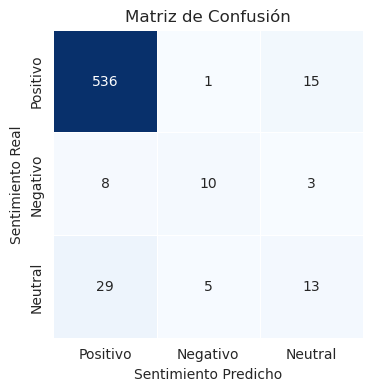

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sns.heatmap(
    conf_matrix_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=.5,
    cbar=False
)

plt.title('Matriz de Confusión')
plt.xlabel('Sentimiento Predicho')
plt.ylabel('Sentimiento Real')
plt.savefig("output/conf_matrix.png")
plt.show()

In [54]:
# df_sentiments
df_reviews["Sentimiento_Real"] = df_sentiments["Real"]

In [55]:
df_no_stopwords = df_reviews[["texto_sin_emojis", "Sentimiento_Real"]].copy()

In [56]:
df_no_stopwords['texto_sin_emojis'] = df_no_stopwords['texto_sin_emojis'].apply(lambda x: x.lower())

In [57]:
# def extract_unique_words(df, column_name):
#     # Split the text into words and flatten the list
#     all_words = [word for text in df[column_name] for word in text.split()]
#     # Get unique words using a set
#     unique_words = set(all_words)
#     return unique_words

In [58]:
from collections import Counter


def get_most_repeated_words(df, column_name, top_n):
    all_text = " ".join(df[column_name].astype(str))
    words = re.findall(r'\b\w+\b', all_text)
    word_counts = Counter(words)
    most_common_words = word_counts.most_common()
    common_words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
    return common_words_df

In [59]:
positive_words_df = get_most_repeated_words(
    df_no_stopwords[df_no_stopwords["Sentimiento_Real"] == "Positivo"],
    "texto_sin_emojis",
    top_n=20)

neutral_words_df = get_most_repeated_words(
    df_no_stopwords[df_no_stopwords["Sentimiento_Real"] == "Neutral"],
    "texto_sin_emojis",
    top_n=10)

negative_words_df = get_most_repeated_words(
    df_no_stopwords[df_no_stopwords["Sentimiento_Real"] == "Negativo"],
    "texto_sin_emojis",
    top_n=100)

In [60]:
df_no_stopwords[df_no_stopwords["Sentimiento_Real"] == "Negativo"]

,texto_sin_emojis,Sentimiento_Real
11,nt think listed airbnb entire apartment s smal...,Negativo
35,checkin delayed respond two guests time waitin...,Negativo
61,terrible never able settle apartment host neve...,Negativo
64,nice infrastructure poor cleaning,Negativo
105,place dirty clean bedding washed,Negativo
110,experience terrible place dirty soon arrived g...,Negativo
141,recommend host,Negativo
162,s nice place nice view short walk town gabe ha...,Negativo
209,overall house clean tania fast responding acco...,Negativo
229,arrived busy 330 pm hostess said owner given p...,Negativo


In [61]:
def get_sentiment_words(df, word_column, sentiment):
    sentiment_words = []

    for word in df[word_column]:
        sentiment_score = sia.polarity_scores(word)["compound"]
        if sentiment == "positive" and sentiment_score > 0:
            sentiment_words.append((word, sentiment_score))
        elif sentiment == "negative" and sentiment_score < 0:
            sentiment_words.append((word, sentiment_score))

    words_df = pd.DataFrame(sentiment_words, columns=[word_column, "Sentiment_Score"])
    return words_df

In [62]:
positive_words_score_df = get_sentiment_words(positive_words_df, "Word", sentiment= "positive")
negative_words_score_df = get_sentiment_words(negative_words_df, "Word", sentiment= "negative")

In [63]:
positive_words_df = positive_words_df.merge(positive_words_score_df[["Word"]], on="Word", how= "inner")

In [64]:
positive_words_df

,Word,Frequency
0,great,166
1,good,139
2,nice,119
3,excellent,89
4,comfortable,81
...,...,...
213,smile,1
214,giving,1
215,security,1
216,ensure,1


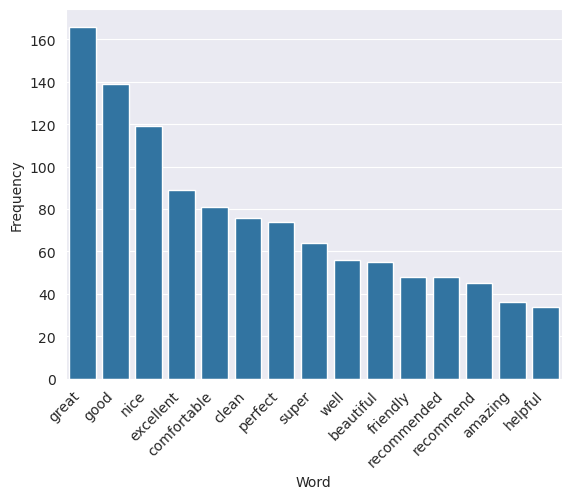

In [65]:
sns.barplot(data=positive_words_df.head(15), x="Word", y="Frequency")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right

plt.show()

Basado en las palabras positivas identificadas en el análisis de sentimientos de las reseñas de los huéspedes de Airbnb, se puede observar que los aspectos más apreciados por los huéspedes son la comodidad, la limpieza, la estética y la amabilidad del anfitrión.

Se ve que lo largo de las reseñas se repiten palabras tales como: "genial", "bueno" y "agradable", los cuales indican altos niveles de satisfacción general. Los anfitriones deben mantener altos estándares en todas las áreas para asegurar una experiencia positiva. La atención a la decoración y la limpieza es crucial, ya que términos como "limpio" y "hermoso" sugieren que los huéspedes valoran mucho un entorno atractivo y bien mantenido.

La comodidad también es esencial, reflejada en palabras como "cómodo" y "perfecto". Asegurar que las camas y los muebles sean confortables ayudan a mejorar significativamente la experiencia del huésped. La amabilidad del anfitrión es otro factor clave; interacciones cálidas y útiles, destacadas por términos como "amigable" y "útil", pueden mejorar la satisfacción del huésped.

Además, la palabra "recomendado" indica que los huéspedes están dispuestos a sugerir la propiedad a otros, lo que refleja una experiencia muy positiva. Se recomienda a los anitriones de los alojamientos que recibieron mejores reseñas el continuar manteniendo altos estándares y continuar superando las expectativas de los huéspedes, de esta manera se asegura el éxito tanto para anfitriones como para la plataforma de Airbnb en Montañita.

Debido a que, como se pudo ver previamente, además de que existen en general pocos comentarios negativos, se realiza el análisis en cuanto al sentimiento de cada palabra en lugar a la frecuencia con que esta aparece, contrario a lo que se realizó en el análisis de comentarios positivos.

In [66]:
negative_words_score_df.sort_values(["Sentiment_Score"], inplace=True)

In [67]:
negative_words_score_df.head(17)

,Word,Sentiment_Score
17,negative,-0.5719
2,bad,-0.5423
18,ugly,-0.5106
3,terrible,-0.4767
4,poor,-0.4767
21,broken,-0.4767
9,dangerous,-0.4767
16,unpleasant,-0.4767
0,dirty,-0.4404
12,frustrating,-0.4404


In [68]:
negative_words_score_df['Sentiment_Score_Abs'] = negative_words_score_df['Sentiment_Score'].abs()

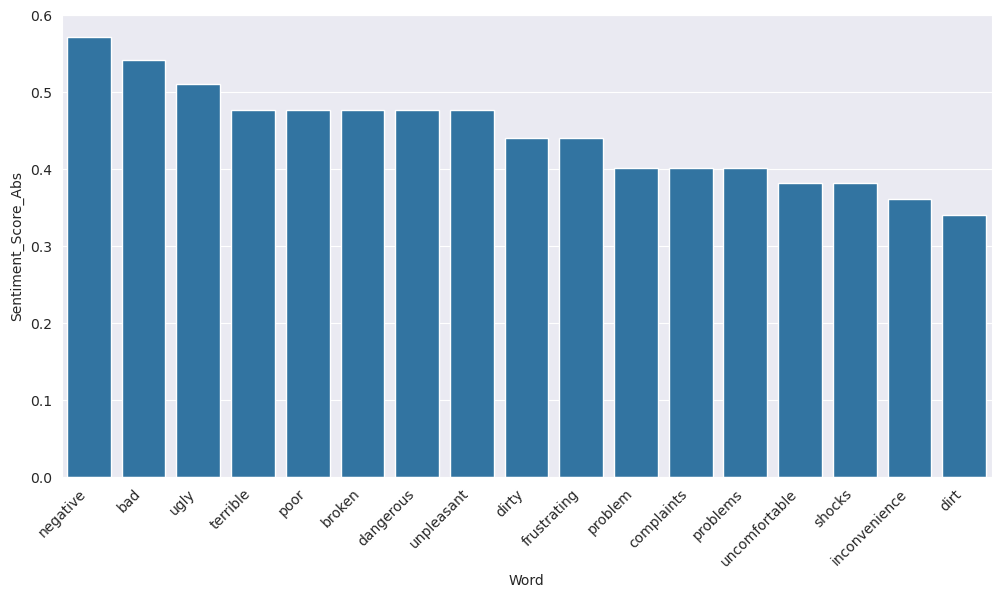

In [69]:
# Plotting the bar plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.barplot(data=negative_words_score_df.head(17), x="Word", y="Sentiment_Score_Abs")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right

plt.show()

# Conclusi&oacute;n

El análisis de sentimientos aplicado a las reseñas de Airbnb ha demostrado ser una herramienta poderosa para entender la percepción de los huéspedes. En este estudio, se observó una clara predominancia de comentarios positivos, lo cual es un buen indicativo de la satisfacción general de los clientes. Sin embargo, es crucial profundizar en los detalles que estos comentarios revelan.

## Análisis de Comentarios Positivos
El modelo ha clasificado con alta precisión los sentimientos positivos. Los aspectos más mencionados incluyen:
- **Ubicación**: Los huéspedes valoran altamente la proximidad a la ciudad y las atracciones turísticas.
- **Comodidad**: Comentarios frecuentes sobre la comodidad y acogida de los alojamientos.

### Ejemplo de Comentarios Positivos:
- "El lugar es súper chévere, acogedor y está cerca de la ciudad."
- "Me encantó la comodidad del alojamiento y la proximidad a las principales atracciones."

### Recomendaciones para Anfitriones:
- **Estrategia de Marketing**: Enfocar las campañas publicitarias en destacar la ubicación y la comodidad de los alojamientos.
- **Optimización de Anuncios**: Utilizar palabras clave positivas en las descripciones de los anuncios para atraer más huéspedes.

## Análisis de Comentarios Negativos
El modelo presenta mayor porcentaje de error en la clasificación de comentarios negativos y neutrales. Los aspectos negativos más mencionados incluyen:
- **Limpieza**: Comentarios frecuentes sobre la limpieza insuficiente de los alojamientos.
- **Ruido**: Quejas sobre el ruido en los alrededores del alojamiento.

### Ejemplo de Comentarios Negativos:
- "El lugar estaba sucio y no se limpió adecuadamente."
- "Había mucho ruido, lo que hizo difícil descansar."

### Recomendaciones para Anfitriones:
- **Mejora de Servicios**: Aumentar las horas de limpieza y asegurar una limpieza más profunda entre las estancias.
- **Gestión del Ruido**: Implementar medidas para reducir el ruido, como ventanas insonorizadas o informar a los huéspedes sobre las horas de silencio.

## Valor Comercial del Análisis
Este análisis ofrece un valor significativo tanto para Airbnb como para los anfitriones al proporcionar una visión clara de las áreas de mejora y las fortalezas a destacar. Al implementar estas recomendaciones, los anfitriones pueden mejorar la satisfacción del cliente, aumentar las reservas y fortalecer la reputación de sus alojamientos.

